### Readme:

1. Download the model t5_base.pt
2. Download the data .csv files
3. Run all the cells till Training.
4. In the inference section, specify the path of the model, load the weights and run on test script

### Imports

In [224]:
from PIL import Image
import os

import numpy as np

import pickle
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from time import sleep
import warnings
import wandb
import torch.nn.functional as F
from rouge import Rouge
import bert_score


from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter


warnings.filterwarnings("ignore") 


In [225]:
# Import T5 model and tokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

In [226]:
# Check GPU
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled   = True

cuda:2


### Read the data

In [227]:
train_data_dir = 'train_data.csv'
val_data_dir = 'val_data.csv'
test_data_dir = 'test_data.csv'

In [228]:
train_df = pd.read_csv(train_data_dir)
val_df = pd.read_csv(val_data_dir)
test_df = pd.read_csv(test_data_dir)

train_df.head()

,Unnamed: 0,document,summary,id
0,0,Recent reports have linked some France-based p...,New Welsh Rugby Union chairman Gareth Davies b...,29750031
1,1,Army explosives experts were called out to dea...,A suspicious package left outside an Alliance ...,28381580
2,2,It has lost its previous triple-A rating from ...,The UK's international reputation for a strong...,34786128
3,3,The warning begins at 22:00 GMT on Saturday an...,The Met Office has issued a yellow weather war...,38785939
4,4,Tony Fisher's body was found by his son in Con...,Two more men have been charged with the murder...,36231761


In [229]:
train_data = train_df['document'].to_list()
train_labels = train_df['summary'].to_list()

val_data = val_df['document'].to_list()
val_labels = val_df['summary'].to_list()

test_data = test_df['document'].to_list()
test_labels = test_df['summary'].to_list()

### Threshold summary
We set the threshold summary length to 3 words. 
So those data with summary less than 3 words will be discarded

In [230]:
for idx, data in enumerate(train_labels):
    item = str(data).replace('\n', '')
    item = item.split()
    if len(item) < 3:
        train_labels.remove(data)
        train_data.remove(train_data[idx])

        
for idx, data in enumerate(val_labels):
    item = str(data).replace('\n', '')
    item = item.split()
    if len(item) < 3:
        val_labels.remove(data)
        val_data.remove(val_data[idx])
        
for idx, data in enumerate(test_labels):
    item = str(data).replace('\n', '')
    item = item.split()
    if len(item) < 3:
        test_labels.remove(data)
        test_data.remove(test_data[idx])
        

In [231]:
train_data_len = []
train_label_len = []

for item in train_data:
    item = str(item).replace('\n', ' ')
    item = item.split()
    train_data_len.append(len(item))

for item in train_labels:
    item = str(item).replace('\n', '')
    item = item.split()
    train_label_len.append(len(item))

    

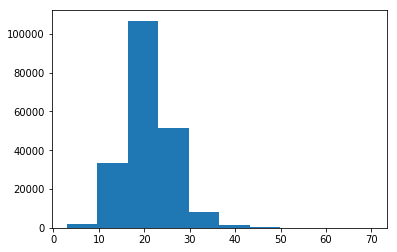

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(train_label_len)
plt.show()

Now minimum summary length is 3 tokens

In [233]:
min(train_label_len)

3

### Dataset and Dataloader

Tokenize the source and summary. Also, adds a special task prefix "summarize:" in the start of every input text

In [234]:

class SummaryData(torch.utils.data.Dataset):
    
    def __init__(self, tokenizer, data, summary, input_length, output_length):     
        
        

        self.input_length = input_length
        self.output_length = output_length
        self.data = data
        self.summary = summary

  
    def __len__(self):
        return len(self.summary)
    
  
    def __getitem__(self, idx):
        
        text = self.data[idx]
        summary = self.summary[idx]
        
        task_prefix = "summarize: "
        
        text = task_prefix + str(text)
        
        source = tokenizer.encode_plus(str(text), max_length=self.input_length, padding='max_length', truncation=True, return_tensors="pt")
        
        summary = tokenizer.encode_plus(str(summary), max_length=self.output_length, padding='max_length', truncation=True)
        
    
        source_ids = source["input_ids"].squeeze()
        src_mask    = source["attention_mask"].squeeze()
        
        summary_ids = summary["input_ids"]
        
        summary_ids = [(label if label != tokenizer.pad_token_id else -100) for label in summary_ids]
        summary_ids = torch.tensor(summary_ids)

        

        return {"input_ids": source_ids, "attention_mask": src_mask, "labels": summary_ids, 'ground_truth': self.summary[idx] }
        
  

### Hyper parameters

In [235]:
## Specify the Hyper parameters 

BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 2e-4
CLIP = 5


input_length = 512
output_length = 100


In [236]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')


In [237]:
wandb.config = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
   "architecture": "T5"
}

### Get the dataset

In [238]:
train_dataset = SummaryData(tokenizer, train_data, train_labels, input_length, output_length)
val_dataset = SummaryData(tokenizer, val_data, val_labels, input_length, output_length)
test_dataset = SummaryData(tokenizer, test_data, test_labels,input_length, output_length)



### Load the T5 Model 

In [239]:
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

In [240]:

## We call the dataloader class
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=2,
    shuffle=True,
    drop_last=True
 )

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=2,
    shuffle=True,
    drop_last=True
 )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=2,
    shuffle=True,
    drop_last=True
 )

dataloaders = {'Train': train_loader, 'Test': test_loader, 'Val': val_loader}



### Optimizer and Rouge

In [241]:
#optimizer
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, eps=1e-8 )
rouge = Rouge()

### Training

In [243]:
PATH = 't5_base.pt'

In [21]:
best_valid_f = 0.000

for epoch in range(0, EPOCHS):
  

    print('-'*50)
    print('Epoch {}/{}'.format(epoch+1, EPOCHS))
    
    scores = []
    f_score = []
    recall = []
    precision = []
    
    batch_loss = 0.0000

    for phase in ['Train', 'Val']:

        if phase == 'Train':
            model.train()
        else:
            model.eval()
            
        
        with tqdm(dataloaders[phase], unit="batch", desc=phase) as tepoch:

          for idx, batch in enumerate(tepoch):
            
                input_ids = batch['input_ids'].to(device)
                
                attention_mask =  batch['attention_mask'].to(device)
                
                labels = batch['labels'].to(device)
                
                ground_truth = batch['ground_truth']
                
                if phase == 'Train':
                
                    out = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)

                    loss = out.loss
                    
                    batch_loss += loss.item()
                    
                    #zero gradients
                    optimizer.zero_grad() 

                    # Backward pass  (calculates the gradients)
                    loss.backward()   

                    # gradient clipping
                    nn.utils.clip_grad_norm_(model.parameters(), CLIP)    

                    optimizer.step()             # Updates the weights
                    
                    tepoch.set_postfix(loss = batch_loss/(idx+1))
                    
                    wandb.log({"Train loss": batch_loss/(idx+1)})
                    
                    
                    
                else:
                    
                    out = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)
                    preds = tokenizer.batch_decode(out, skip_special_tokens=True)
                    
                    #get rouge score
                    score = rouge.get_scores(preds, ground_truth)
                    
                    scores.extend(score)

                    
                    for item in scores:
                        rouge_2 = item['rouge-2']
                        f_score.append(rouge_2['f'])
                        recall.append(rouge_2['p'])
                        precision.append(rouge_2['r'])
                        
                    
                    tepoch.set_postfix(f_score=np.mean(np.array(f_score)), recall= np.mean(np.array(recall)), precision = np.mean(np.array(precision)) )
                   
                    wandb.log({'Val f_score': np.mean(np.array(f_score))})
                    
                    wandb.log({'Val precision': np.mean(np.array(precision))})
                    
                    wandb.log({'Val recall': np.mean(np.array(recall))})
                    
    
                    
                

    torch.save(model.state_dict(), PATH)
    print('Model Saved!')
           

--------------------------------------------------
Epoch 1/3


Val: 100%|██████████| 708/708 [34:04<00:00,  2.89s/batch, f_score=0.084, precision=0.0722, recall=0.106]  


Model Saved!
--------------------------------------------------
Epoch 2/3


Val: 100%|██████████| 708/708 [33:43<00:00,  2.86s/batch, f_score=0.0907, precision=0.0778, recall=0.114]


Model Saved!
--------------------------------------------------
Epoch 3/3


Val: 100%|██████████| 708/708 [38:38<00:00,  3.27s/batch, f_score=0.0973, precision=0.0835, recall=0.122]


Model Saved!


### Inference:

In [20]:
PATH = 't5_base.pt'

model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

In [21]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Test script:

In [196]:

# set the model to evaluation mode            
model.eval()

scores = []

f_score = []
recall = []
precision = []

predicted  = []
true = []
        
with tqdm(test_loader, unit="batch", desc= "Test") as tepoch:
    
  for batch in tepoch:
    input_ids = batch['input_ids'].to(device)
                
    attention_mask =  batch['attention_mask'].to(device)
                
    labels = batch['labels'].to(device)
                
    ground_truth = batch['ground_truth']

    with torch.no_grad():
        
        out = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)
        
        preds = tokenizer.batch_decode(out, skip_special_tokens=True)
        
        predicted.extend(preds)
        true.extend(ground_truth)
                    
        #get rouge score
        score = rouge.get_scores(preds, ground_truth)
                    
        scores.extend(score)
                                

for item in scores:
    
    rouge_2 = item['rouge-2']
    f_score.append(rouge_2['f'])
    recall.append(rouge_2['p'])
    precision.append(rouge_2['r'])
        
f = np.mean(np.array(f_score))
    
p = np.mean(np.array(precision))
    
r = np.mean(np.array(recall))

print("Test Rouge-2:  f: {:.4f}, p: {:.4f}, r : {:.4f}.".format(f, p, r))

Test: 100%|██████████| 1416/1416 [05:11<00:00,  4.55batch/s]

Test Rouge-2:  f: 0.0950, p: 0.0817, r : 0.1193.


### Visualize rouge_2 f values

In [63]:
scores2 = []

In [64]:
for index in tqdm(range(len(test_dataset))):
    
    input_ids = test_dataset[index]['input_ids'].unsqueeze(0).to(device)
    input_text = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

    attention_mask = test_dataset[index]['attention_mask'].unsqueeze(0).to(device)

    summary = test_dataset[index]['ground_truth']
    
    
    with torch.no_grad():

        output = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)

        predicted = tokenizer.batch_decode(output, skip_special_tokens=True)
        
        score2 = rouge.get_scores(predicted[0], summary)
        
        scores2.extend(score2)
    
    

100%|██████████| 11333/11333 [1:05:30<00:00,  2.88it/s]


In [85]:
f_score2 = []
recall2 = []
precision2 = []

for item in scores2:
    
    rouge_2 = item['rouge-2']
    f_score2.append(rouge_2['f'])
    recall2.append(rouge_2['p'])
    precision2.append(rouge_2['r'])
        
f = np.mean(np.array(f_score2))
    
p = np.mean(np.array(recall2))
    
r = np.mean(np.array(precision2))


In [166]:
# Range of f scores 


indices_0 = [i for i,v in enumerate(f_score2) if v == 0.00]
indices_2 = [i for i,v in enumerate(f_score2) if v > 0.00 and v <= 0.04]
indices_3 = [i for i,v in enumerate(f_score2) if v > 0.04 and v <= 0.08]
indices_4 = [i for i,v in enumerate(f_score2) if v > 0.08 and v <= 0.15]
indices_5 = [i for i,v in enumerate(f_score2) if v > 0.15 and v <= 0.3]
indices_6 = [i for i,v in enumerate(f_score2) if v > 0.3 and v <= 0.5]
indices_7 = [i for i,v in enumerate(f_score2) if v > 0.5 and v <= 0.7]
indices_8 = [i for i,v in enumerate(f_score2) if v > 0.7 and v <= 0.9]
indices_9 = [i for i,v in enumerate(f_score2) if v > 0.9 and v <= 1.0]

In [167]:
count_0 = len(indices_0)
count_2 = len(indices_2)
count_3 = len(indices_3)
count_4 = len(indices_4)
count_5 = len(indices_5)
count_6 = len(indices_6)
count_7 = len(indices_7)
count_8 = len(indices_8)
count_9 = len(indices_9)


count = [count_0, count_2, count_3, count_4, count_5, count_6, count_7, count_8, count_9]

In [168]:
# count of values for different f scores
print(count)

[4143, 19, 2693, 1873, 1893, 621, 64, 15, 12]


In [161]:
#Indices of samples that generate perfect summary
print(indices_8)

[459, 722, 748, 950, 1407, 2212, 2293, 2428, 5062, 6050, 7305, 7502, 8077, 8809, 9740]


Count of f2 values

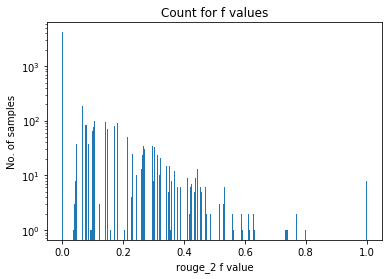

In [162]:
import numpy as np
import matplotlib.pyplot as plt
 
 
# Plotting the Graph
plt.hist(f_score2, bins = 1000)
plt.title("Count for f values")
plt.xlabel("rouge_2 f value")
plt.ylabel("No. of samples")
plt.yscale('log')
plt.show()


### Analyze Outputs:

Take 1 example from test data

In [77]:
index  = 756
input_ids = test_dataset[index]['input_ids'].unsqueeze(0).to(device)
input_text = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

attention_mask = test_dataset[index]['attention_mask'].unsqueeze(0).to(device)

summary = test_dataset[index]['ground_truth']
    
output = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)

predicted = tokenizer.batch_decode(output, skip_special_tokens=True)


print('Input Text:', input_text[0])
print()
print("Ground Truth:", summary) 
print()
print("Predicted:", predicted[0])
        

Input Text: summarize: A selection of your pictures of Scotland sent in between 6 and 13 January. Send your photos to scotlandpictures@bbc.co.uk or our Instagram at #bbcscotlandpics.

Ground Truth: All pictures are copyrighted.

Predicted: All pictures are copyrighted.


In [147]:
index  = 4747
input_ids = test_dataset[index]['input_ids'].unsqueeze(0).to(device)
input_text = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

attention_mask = test_dataset[index]['attention_mask'].unsqueeze(0).to(device)

summary = test_dataset[index]['ground_truth']
    
output = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)

predicted = tokenizer.batch_decode(output, skip_special_tokens=True)


print('Input Text:', input_text[0])
print()
print("Ground Truth:", summary) 
print()
print("Predicted:", predicted[0])
        

Input Text: summarize: If you have a picture you would like to share, please see below the images for details on how to submit yours. If you have a picture you'd like to share, email us at england@bbc.co.uk, post it on Facebook or tweet it to @BBCEngland. You can also find us on Instagram - use #englandsbigpicture to share an image there. When emailing pictures, please make sure you include the following information: Please note that whilst we welcome all your pictures, we are more likely to use those which have been taken in the past week. If you submit a picture, you do so in accordance with the BBC's Terms and Conditions. In contributing to England's Big Picture you agree to grant us a royalty-free, non-exclusive licence to publish and otherwise use the material in any way that we want, and in any media worldwide. It's important to note, however, that you still own the copyright to everything you contribute to England's Big Picture, and that if your image is accepted, we will publis

In [144]:
index  = 231
input_ids = test_dataset[index]['input_ids'].unsqueeze(0).to(device)
input_text = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

attention_mask = test_dataset[index]['attention_mask'].unsqueeze(0).to(device)

summary = test_dataset[index]['ground_truth']
    
output = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)

predicted = tokenizer.batch_decode(output, skip_special_tokens=True)


print('Input Text:', input_text[0])
print()
print("Ground Truth:", summary) 
print()
print("Predicted:", predicted[0])

Input Text: summarize: The 24-year-old was an injury-time substitute for the Cherries in their 2-1 win at Aston Villa on Saturday. Wilson, Bournemouth's leading scorer last season, missed six months of the club's first Premier League campaign with medial knee ligament damage. "There's nothing like being back out on the pitch," he told BBC Radio Solent. "It was only a few touches, but it's nice to feel like a football player again." The former Coventry City striker required surgery following the injury he sustained against Stoke in September and revealed his return came a week earlier than planned. "I'd originally targeted the Liverpool game (at home on Sunday), but one week sooner is perfect for me," added Wilson. "There's a little bit of match fitness still to regain, but I feel strong and ready."

Ground Truth: Bournemouth striker Callum Wilson said it was "great to feel like a football player again" as he returned to action following a long-term injury.

Predicted: Bournemouth strik

In [181]:
#samples that have 0 f score
print(indices_0[:41])

[0, 1, 8, 11, 12, 17, 18, 23, 25, 27, 30, 32, 35, 37, 41, 43, 48, 50, 52, 55, 56, 58, 61, 62, 63, 64, 66, 67, 69, 70, 73, 78, 80, 81, 82, 85, 93, 95, 97, 101, 102]


In [211]:
index  = 101
input_ids = test_dataset[index]['input_ids'].unsqueeze(0).to(device)
input_text = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

attention_mask = test_dataset[index]['attention_mask'].unsqueeze(0).to(device)

summary = test_dataset[index]['ground_truth']
    
output = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)

predicted = tokenizer.batch_decode(output, skip_special_tokens=True)


print('Input Text:', input_text[0])
print()
print("Ground Truth:", summary) 
print()
print("Predicted:", predicted[0])

Input Text: summarize: Michael D Higgins will ask the Council of State if the Protection of Life During Pregnancy Bill's legality should be tested by the Supreme Court. The bill would allow a termination when doctors deem that a woman is at risk of taking her life. President Higgins must decide by Wednesday whether to sign the bill into law or refer it to the court. If the Supreme Court decides it is constitutional and approves the bill, it will automatically become law and its constitutionality could never be subsequently challenged. It the first time that President Higgins has convened the Council of State since he assumed office in November 2011. The Council of State is an advisory body that aids and counsels the president. The introduction of the legislation follows the case of an Indian woman who died in an Irish hospital after she was refused an abortion. The debate revealed deep splits in the predominantly Catholic country. Anti-abortion campaigners say that the bill will allow 

In [213]:
rouge.get_scores(predicted[0], summary)

[{'rouge-1': {'f': 0.12903225306971924, 'p': 0.13333333333333333, 'r': 0.125},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.06451612403746138,
   'p': 0.06666666666666667,
   'r': 0.0625}}]

### Using BERT SCORE

In [201]:
from bert_score import score

predicted = ['Perfect day for hiking']
true = ['Such a beautiful weather for trekking']

P, R, F1 = score(predicted, true, lang='en', verbose=True)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.32 sentences/sec


In [202]:
P, R, F1

(tensor([0.9209]), tensor([0.9093]), tensor([0.9151]))

In [193]:
from bert_score import score

true = [summary]

P, R, F1 = score(predicted, true, lang='en', verbose=True)

P, R, F1

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.40 sentences/sec


(tensor([0.9026]), tensor([0.8882]), tensor([0.8953]))

In [195]:
predicted

['The President of the Republic of Ireland is to ask the Supreme Court to consider a bill that']

### BERT score on test dataset

In [206]:


# set the model to evaluation mode            
model.eval()

scores = []

f_score = []
recall = []
precision = []

predicted  = []
true = []
        
with tqdm(test_loader, unit="batch", desc= "Test") as tepoch:
    
  for batch in tepoch:
    input_ids = batch['input_ids'].to(device)
                
    attention_mask =  batch['attention_mask'].to(device)
                
    labels = batch['labels'].to(device)
                
    ground_truth = batch['ground_truth']

    with torch.no_grad():
        
        out = model.generate(input_ids= input_ids, attention_mask =  attention_mask, do_sample=False)
        
        preds = tokenizer.batch_decode(out, skip_special_tokens=True)
        
        predicted.extend(preds)
        true.extend(ground_truth)
                    
        #get rouge score
        score = rouge.get_scores(preds, ground_truth)
                    
        scores.extend(score)
                                

for item in scores:
    
    rouge_2 = item['rouge-2']
    f_score.append(rouge_2['f'])
    recall.append(rouge_2['p'])
    precision.append(rouge_2['r'])
    

f = np.mean(np.array(f_score))
    
p = np.mean(np.array(precision))
    
r = np.mean(np.array(recall))

Test: 100%|██████████| 1416/1416 [05:22<00:00,  4.40batch/s]


In [208]:
len(predicted), len(true)

(11328, 11328)

In [210]:
from bert_score import score

P, R, F1 = score(predicted, true, lang='en', verbose=True)

print("Test BERT score: f: {:.4f}, p: {:.4f}, r : {:.4f}.".format(F1.mean(), P.mean(), R.mean()))

print("Test Rouge-2:  f: {:.4f}, p: {:.4f}, r : {:.4f}.".format(f, p, r))

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/354 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/177 [00:00<?, ?it/s]

done in 41.34 seconds, 274.02 sentences/sec
Test BERT score: f: 0.8837, p: 0.8932, r : 0.8745.
Test Rouge-2:  f: 0.0950, p: 0.0816, r : 0.1193.


### WCN on test data

In [244]:
f_score_mix = []
recall_mix = []
precision_mix = []


#get rouge_2 and rouge_1 metrics
for item in scores:
    
    rouge_2 = item['rouge-2']
    f_score_mix.append(rouge_2['f'])
    recall_mix.append(rouge_2['p'])
    precision_mix.append(rouge_2['r'])

    rouge_1 = item['rouge-1']
    f_score_mix.append(rouge_2['f'])
    recall_mix.append(rouge_2['p'])
    precision_mix.append(rouge_2['r'])
    

# get bertscore    
f_score_mix.extend(F1.detach().cpu().numpy().tolist())
recall_mix.extend(R.detach().cpu().numpy().tolist())
precision_mix.extend(P.detach().cpu().numpy().tolist())
    
    
# take the average
f = np.mean(np.array(f_score_mix))
    
p = np.mean(np.array(recall_mix))
    
r = np.mean(np.array(precision_mix))

print("WCN Score on Test data:  f: {:.4f}, p: {:.4f}, r : {:.4f}.".format(f, p, r))

WCN Score on Test data:  f: 0.3579, p: 0.3711, r : 0.3522.
